## Housing Prices Machine Learning Notebook


In this notebook we will be working with a Kaggle dataset of housing prices, and we will attempt to pre process the data and extract useful features in order to run Linear Regression for predicting the house's sale price.


Haren Bhavnani

In [4]:
# run this if you would like to mount your drive
from google.colab import drive
drive.mount("/content/drive/")
baseDir = "drive/My Drive/Colab Notebooks/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import *

First let's split our dataframe into a train and test split, so that we can use part of the data for hyperparameter tuning before fitting a model onto the unlabelled dataset. Let's also explore a few rows of our dataset as well as certain properties (such as the shape, statistics about the numerical features, etc.)

In [47]:
df = pd.read_csv(baseDir+"train.csv")  # import file
df_test = pd.read_csv(baseDir+"test.csv")

from sklearn.model_selection import train_test_split
df_train, df_dev = train_test_split(df, test_size=0.3, random_state = 42)

df_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
135,136,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,7,6,1970,1970,Hip,CompShg,Plywood,Plywood,BrkFace,288.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,1304,1304,GasA,...,Y,SBrkr,1682,0,0,1682,0,0,2,0,3,1,TA,7,Typ,1,Gd,Attchd,1970.0,Unf,2,530,TA,TA,Y,98,0,0,0,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,174000
1452,1453,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,SLvl,5,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,BrkFace,80.0,TA,TA,PConc,Gd,TA,Gd,GLQ,547,Unf,0,0,547,GasA,...,Y,SBrkr,1072,0,0,1072,1,0,1,0,2,1,TA,5,Typ,0,NaN,Basment,2005.0,Fin,2,525,TA,TA,Y,0,28,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,145000
762,763,60,FV,72.0,8640,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2009,2009,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Mn,GLQ,24,Unf,0,732,756,GasA,...,Y,SBrkr,764,783,0,1547,0,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,2009.0,Unf,2,614,TA,TA,Y,169,45,0,0,0,0,NaN,NaN,NaN,0,6,2010,Con,Normal,215200
932,933,20,RL,84.0,11670,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Somerst,RRNn,Norm,1Fam,1Story,9,5,2006,2006,Hip,CompShg,VinylSd,ImStucc,Stone,302.0,Ex,TA,PConc,Ex,Gd,No,Unf,0,Unf,0,1905,1905,GasA,...,Y,SBrkr,1905,0,0,1905,0,0,2,0,3,1,Ex,8,Typ,1,Gd,Attchd,2006.0,Fin,3,788,TA,TA,Y,0,191,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,320000
435,436,60,RL,43.0,10667,Pave,NaN,IR2,Lvl,AllPub,CulDSac,Gtl,CollgCr,PosN,Norm,1Fam,2Story,7,6,1996,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,385,ALQ,344,70,799,GasA,...,Y,SBrkr,827,834,0,1661,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,1996.0,RFn,2,550,TA,TA,Y,158,61,0,0,0,0,NaN,NaN,NaN,0,4,2009,ConLw,Normal,212000
629,630,80,RL,82.0,9020,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Feedr,Norm,1Fam,SLvl,6,5,1964,1964,Gable,WdShngl,Plywood,Wd Sdng,BrkFace,259.0,TA,TA,CBlock,TA,TA,Gd,GLQ,624,Rec,336,288,1248,GasA,...,Y,SBrkr,1350,0,0,1350,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1964.0,RFn,2,520,TA,TA,Y,176,0,0,0,0,0,NaN,GdPrv,NaN,0,6,2008,WD,Normal,168500
1210,1211,60,RL,70.0,11218,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1055,1055,GasA,...,Y,SBrkr,1055,790,0,1845,0,0,2,1,3,1,Gd,8,Typ,1,TA,Attchd,1992.0,RFn,2,462,TA,TA,Y,635,104,0,0,0,0,NaN,GdPrv,Shed,400,5,2010,WD,Normal,189000
1118,1119,80,RL,85.0,13825,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,SLvl,5,6,1958,1987,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Unf,0,Unf,0,533,533,GasA,...,Y,SBrkr,1021,580,0,1601,0,1,1,0,3,1,TA,6,Min2,0,NaN,BuiltIn,1958.0,RFn,1,300,TA,TA,Y,280,34,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,140000
1084,1085,60,RL,NaN,13031,Pave,NaN,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1995,1996,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,ALQ,592,Unf,0,99,691,GasA,...,Y,SBrkr,691,807,0,1498,0,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1995.0,Fin,2,409,TA,TA,Y,315,44,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,187500
158,159,60,FV,100.0,12552,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,N

In [48]:
print('Train size = ' + str(df_train.shape))
print('Dev size = '+ str(df_dev.shape))
print('Training Data:')
df_train.describe()

Train size = (1022, 81)
Dev size = (438, 81)
Training Data:


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1022.000000,1022.000000,832.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1019.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,968.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,732.338552,57.059687,70.375000,10745.437378,6.128180,5.564579,1970.995108,1984.757339,105.261040,446.176125,42.368885,571.223092,1059.768102,1169.737769,353.738748,5.766145,1529.242661,0.422701,0.059687,1.582192,0.374755,2.890411,1.045010,6.545010,0.613503,1978.676653,1.783757,477.120352,97.548924,49.525440,21.303327,3.881605,15.565558,2.743640,41.565558,6.363992,2007.814090,181312.692759
std,425.860402,42.669715,25.533607,11329.753423,1.371391,1.110557,30.748816,20.747109,172.707705,459.971174,151.210531,446.004532,447.423437,389.550515,441.124963,47.949564,530.971805,0.519354,0.241119,0.544401,0.494305,0.811116,0.212096,1.630221,0.650724,24.814634,0.730751,208.443296,131.691873,69.205968,61.534380,32.547722,56.445749,39.671531,338.132358,2.650115,1.325807,77617.461005
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,367.500000,20.000000,59.000000,7564.250000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,0.000000,223.250000,795.000000,889.750000,0.000000,0.000000,1142.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,350.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,735.500000,50.000000,70.000000,9600.000000,6.000000,5.000000,1972.000000,1994.000000,0.000000,390.000000,0.000000,483.500000,995.000000,1096.500000,0.000000,0.000000,1476.500000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,484.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,165000.000000
75%,1100.500000,70.000000,80.000000,11692.500000,7.000000,6.000000,2001.000000,2004.000000,170.000000,724.000000,0.000000,809.500000,1294.000000,1392.000000,731.250000,0.000000,1794.250000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,170.500000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,215000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,1127.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,2.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000,745000.000000


Let's have a look at the missing values in the dataset, to decide which features to drop.

In [40]:
# Examine the dataset for missing features
print('Percentage of instances with missing features:')
percent_missing_values = (df_train.isnull().sum(axis=0)/df_train.shape[0]).sort_values(ascending=False)
percent_missing_values = percent_missing_values[percent_missing_values > 0]
print(percent_missing_values)
print()

Percentage of instances with missing features:
PoolQC          0.995108
MiscFeature     0.960861
Alley           0.935421
Fence           0.802348
FireplaceQu     0.476517
LotFrontage     0.185910
GarageCond      0.052838
GarageType      0.052838
GarageYrBlt     0.052838
GarageFinish    0.052838
GarageQual      0.052838
BsmtFinType1    0.025440
BsmtExposure    0.025440
BsmtCond        0.025440
BsmtQual        0.025440
BsmtFinType2    0.025440
MasVnrArea      0.002935
MasVnrType      0.002935
Electrical      0.000978
dtype: float64



Note that while Fence has 80% missing values, we will not drop it since within the data description it mentions that a value of N/A for certain features (including fence) means that there is no fence on the property, which is information that we can use to increase the predictive power of our model.

In [49]:
# drop features with majority NA values + Id column. MiscVal goes with MiscFeature
# save test ids for Kaggle submission
df_train = df_train.drop(['PoolQC', 'MiscFeature', 'MiscVal', 'Id'], axis = 1)        
df_dev= df_dev.drop(['PoolQC', 'MiscFeature', 'MiscVal', 'Id'], axis = 1)  
test_ids = df_test['Id']       
df_test= df_test.drop(['PoolQC', 'MiscFeature', 'MiscVal', 'Id'], axis = 1)

Now lets visualize some of our features, we will look at any feature with a correlation value higher than 0.34 and visualize the relationship between that feature and our target variable.

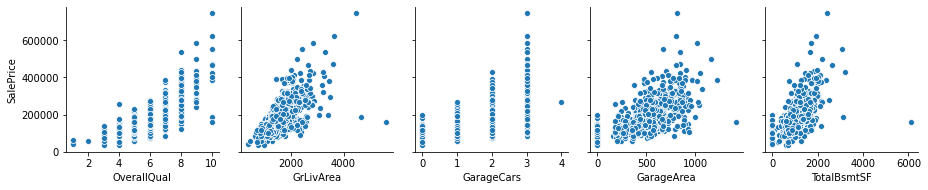

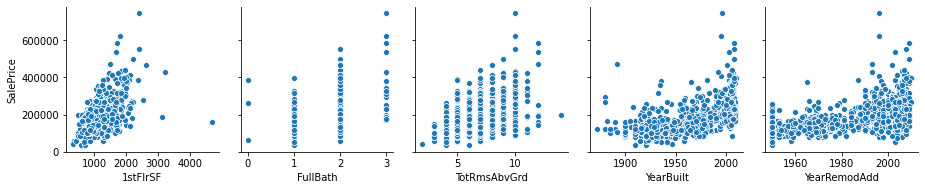

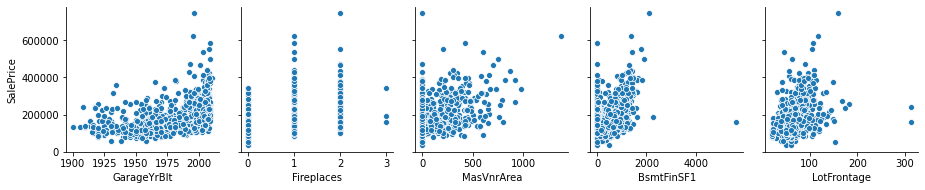

In [23]:
# Identify the features most correlated with SalePrice
correlations = df_train.corr()['SalePrice'].abs()        # view the correlation score of each feature with target variable
correlations = correlations[correlations.abs() > 0.34].sort_values(ascending=False)
correlations_cols = correlations.keys().tolist()
correlations_cols.remove('SalePrice')

# Divide those features into sets of 5
column_sets_to_plot = [correlations_cols[i:i+5] 
                   for i in range(0, len(correlations_cols), 5)] 

# Plot each set of five features against the SalePrice
import seaborn as sns
for column_set in column_sets_to_plot:
  sns.pairplot(df_train, x_vars=column_set, y_vars='SalePrice')

In [50]:
# notice the outliers that lie above approximately 4000 living room area
df_train = df_train[df_train.GrLivArea < 4000]   # drop the outliers

In [43]:
null_cols = df_train.columns[df_train.isna().any()].tolist()
null_cols_test = df_test.columns[df_test.isna().any()].tolist()
for col in null_cols_test:
    if col not in null_cols:
        null_cols.append(col)
        
        
print(null_cols)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea', 'SaleType']


Here we are going to sort our features into 3 categories, we will have numeric columns which include continuous values, and then we want to separate discrete valued columns into two categories, ordinals and categorical. 

Ordinal columns will be those where we want to preseve the relative order between categories, i.e for "Basement Quality" a value of 2 indicates a higher quality basement than a value of 1, and thus will likely lead to a higher house price. These features will therefore be represented numerically, with 0 representing the worst quality, and a higher number implying a 'better' value for that aspect of the house. Categorical columns on the other hand do not have this relation, for example looking through the description of the "RoofStyle" feature it is not clear which styles could be considered 'better' than others, so these features will be one hot encoded.

Note that for these ordinal columns, a value of NA doesn't mean that the feature value is missing, but rather that the aspect of the house that it represents does not exist on that house, i.e. "Fireplace Quality" = NA implies that the house represented by that row does not contain a fireplace, so we will represent this absence with a value of 0, and therefore for these columns 1 will represent the lowest quality category rather than 0.

In [51]:
print(df_train[['HouseStyle','FullBath', 'RoofMatl','BsmtCond','KitchenQual']].head(10))

#ORDINALS (19)
ordinals = {
  'LotShape': {'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4},
  'LandSlope': {'Sev':1, 'Mod':2, 'Gtl':3},
  'ExterQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
  'ExterCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
  'BsmtQual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
  'BsmtCond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
  'BsmtExposure': {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
  'BsmtFinType1': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
  'BsmtFinType2': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
  'HeatingQC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},       
  'KitchenQual': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, 
  'Functional': {'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8},
  'FireplaceQu': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
  'GarageFinish': {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3},
  'GarageQual': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
  'GarageCond': {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
  'PavedDrive': {'N':0, 'P':1, 'Y':2},
  'Fence': {'NA':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4}}

  #  'PoolQC': {'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4},

ordinal_cols = ordinals.keys()
       


#CATEGORICAL (25)
categorical_cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 
                    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                    'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 
                    'GarageType', 'SaleType', 'SaleCondition']



	

#NUMERIC (35)
numeric_cols = ['LotFrontage', 'LotArea', 'OverallQual', 
                'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
                'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
                'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
                'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 
                'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                'MoSold', 'YrSold', 'SalePrice']


# Replace ordinals in the dataset
for col,ordinal_map in ordinals.items():
  df_train[col] = df_train[col].replace(ordinal_map)
  df_dev[col] = df_dev[col].replace(ordinal_map)
  df_test[col] = df_test[col].replace(ordinal_map)

print(df_train[['HouseStyle','FullBath', 'RoofMatl','BsmtCond','KitchenQual']].head(10))


     HouseStyle  FullBath RoofMatl BsmtCond KitchenQual
135      1Story         2  CompShg       TA          TA
1452       SLvl         1  CompShg       TA          TA
762      2Story         2  CompShg       TA          Gd
932      1Story         2  CompShg       Gd          Ex
435      2Story         2  CompShg       TA          Gd
629        SLvl         1  WdShngl       TA          TA
1210     2Story         2  CompShg       TA          Gd
1118       SLvl         1  CompShg       TA          TA
1084     2Story         2  CompShg       TA          TA
158      2Story         2  CompShg       TA          Gd
     HouseStyle  FullBath RoofMatl  BsmtCond  KitchenQual
135      1Story         2  CompShg       3.0            3
1452       SLvl         1  CompShg       3.0            3
762      2Story         2  CompShg       3.0            4
932      1Story         2  CompShg       4.0            5
435      2Story         2  CompShg       3.0            4
629        SLvl         1  WdShngl  

Now we will impute missing values. Since Sklearn models do not accept missing values within the input data, we are going to impute the missing values. For categorical and ordinal columns we will impute with the mode, whereas for continunous valued columns we shall use the mean.

Note that we fill in the test data's missing values with the statistics from the training data, as we want to consider the test data values relative to the training data since our model will be learning on the training data.

In [52]:
# Impute missing values

values_dict = {}      # create a dictionary to use for imputing each column
for col in numeric_cols: 
    values_dict[col] = df_train[col].mean()  # take the mean of numeric cols
for col in categorical_cols:
    values_dict[col] = df_train[col].mode()[0]  # take the mode of categorical vars
for col in ordinal_cols:
    values_dict[col] = df_train[col].mode()[0]  # take the mode of ordinal vars

    
df_train = df_train.fillna(values_dict)     # use the dictionary with fillna funciton
df_dev = df_dev.fillna(values_dict)
df_test = df_test.fillna(values_dict)

Time to one hot encode all of our categorical variables. It is important here to note that certain values in the training set may not occur in the testing set, so after one hot encoding we will check to see if there exist any columns in the trainining dataframe that aren't in the test dataframe, and set the values of those columns to 0

In [55]:
# print('Train size before OHE encoding = ' + str(df_train.shape))
# print('Dev size before OHE encoding = ' + str(df_dev.shape))
# print('Test size before OHE encoding = ' + str(df_test.shape))
# for col in categorical_cols:
#     dummies_train = pd.get_dummies(df_train[col], prefix = col)      # one hot encode all string valued columns
#     dummies_dev = pd.get_dummies(df_dev[col], prefix = col) 
#     dummies_test = pd.get_dummies(df_test[col], prefix = col) 
#     df_train = pd.concat([df_train, dummies_train], axis = 1)
#     df_dev = pd.concat([df_dev, dummies_dev], axis = 1)
#     df_test = pd.concat([df_test, dummies_test], axis = 1)


# df_train = df_train.drop(categorical_cols, axis = 1)      # drop the non OHE columns
# df_dev = df_dev.drop(categorical_cols, axis = 1) 
# df_test = df_test.drop(categorical_cols, axis = 1)        

# The problem is that values that were present in the training set and not in the test set (or vice versa)
# can cause the set of columns appended by one-hot encoding to differ.  Therefore, we must fix the test set
# columns to exactly match the training set columns.
# Get missing cols in the training test
missing_cols_dev = set(df_train.columns) - set(df_dev.columns)
missing_cols_test = set(df_train.columns) - set(df_test.columns)
# Add missing columns into the test set with a value of 0 (false)
for col in missing_cols_dev:
    df_dev[col] = 0
for col in missing_cols_test:
    df_test[col] = 0
# Ensure the column order in the test set matches the column order in the training set, 
# and that there aren't additional columns in the test set that aren't in the training set
df_dev = df_dev[df_train.columns]
df_test = df_test[df_train.columns]

print('Train size after OHE encoding = ' + str(df_train.shape))
print('Dev size after OHE encoding = ' + str(df_dev.shape))
print('Test size after OHE encoding = ' + str(df_test.shape))

Train size after OHE encoding = (1019, 226)
Dev size after OHE encoding = (438, 226)
Test size after OHE encoding = (1459, 226)


Just A sanity check now that we have no missing values

In [57]:
# Confirm that we have no missing values in the training or testing data at this point
print('df_train: num missing values = ' + str(df_train.isna().sum().sum()))
print()
print('df_dev: num missing values = ' + str(df_dev.isna().sum().sum()))
print()
print('df_test: num missing values = ' + str(df_test.isna().sum().sum()))

df_train: num missing values = 0

df_dev: num missing values = 0

df_test: num missing values = 0


Let's do some analysis on our numeric columns, a correlation matrix can show us the importance of each feature towards our target variable


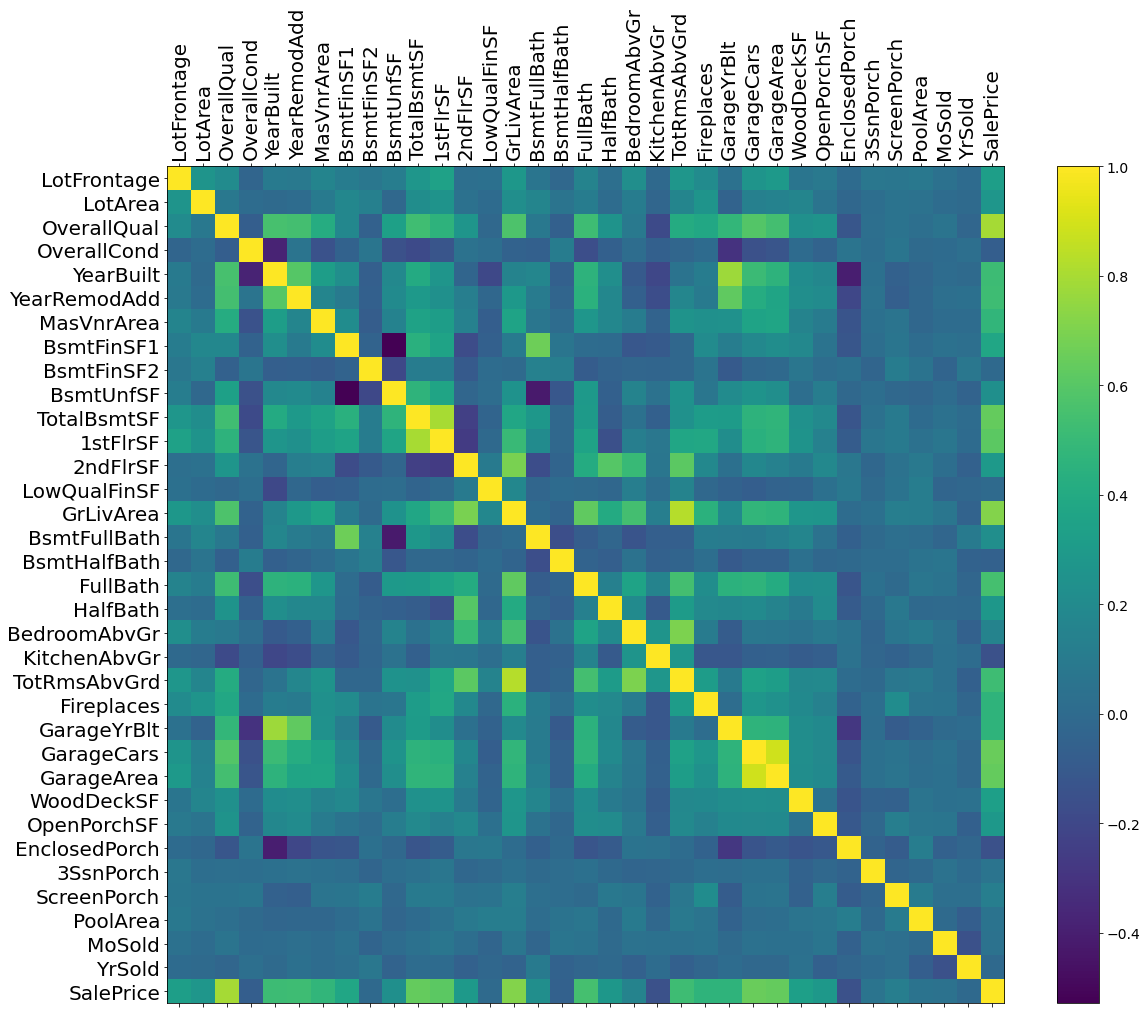

In [58]:
f = plt.figure(figsize = (19,15))         # produce a correlation matrix for numeric columns
plt.matshow(df_train[numeric_cols].corr(),fignum=f.number)
plt.xticks(range(len(numeric_cols)), numeric_cols, fontsize=20, rotation = 90)
plt.yticks(range(len(numeric_cols)), numeric_cols,  fontsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
f.show()

Now let's run a regression model!  As a baseline model we will first use all of the features in the dataset, and then we will look at filtering out some of the less important features.

In [59]:
X_train = df_train.copy()
X_train = X_train.drop('SalePrice', axis=1)        # drop the target variable before running a model
y_train = df_train['SalePrice']                    # set the target variable

X_dev = df_dev.copy()
X_dev = X_dev.drop('SalePrice', axis=1)        # drop the target variable 
y_dev = df_dev['SalePrice']                    # set the target variable

X_test = df_test.copy()


# Fit model
lr = linear_model.LinearRegression()      # fit linear regression on all features
lr.fit(X_train, y_train)

# Evaluate
print(lr.score(X_dev, y_dev))

0.8843509960513352


Now let's try some feature selection, we will decide on a correlation threshold for each feature and any feature that has a correlation with the target variable that is lower than that threshold will be dropped.

The optimal dataset has 137 features.


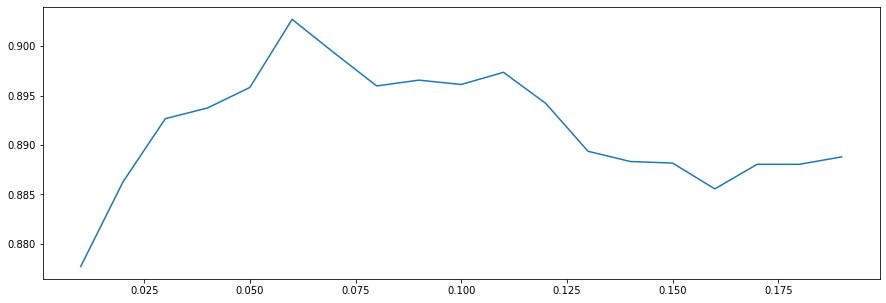

In [61]:
thresholds = np.arange(0.01,0.2, 0.01)
scores = []
for threshold in thresholds:
  corrs = df_train.corr()['SalePrice'].abs()
  corrs = corrs[corrs > threshold]
  corrs.drop('SalePrice', inplace=True)
  X_train2 = X_train[corrs.keys()]
  X_dev2 = X_dev[corrs.keys()]
  # Fit model
  lr = linear_model.LinearRegression()
  lr.fit(X_train2, y_train)

  # Evaluate
  score = lr.score(X_dev2, y_dev)
  scores.append(score)

plt.figure(figsize=(15,5))
plt.plot(thresholds, scores)

corrs = df_train.corr()['SalePrice'].abs()
corrs = corrs[corrs > thresholds[np.argmax(scores)]]
corrs.drop('SalePrice', inplace=True)
print(f"The optimal dataset has {len(X_train[corrs.keys()].columns)} features.")

We get our highest model score at a threshold of about 0.06, indicating that even features with quite a low correlation are still useful in our model! We end up dropping around 40% of our features though, and from the higher score without these features we can infer that they were adding a decent amount of noise to our model.

In [62]:
X_train2 = X_train[corrs.keys()]
X_dev2 = X_dev[corrs.keys()]
# Fit model
lr = linear_model.LinearRegression()
lr.fit(X_train2, y_train)

# Evaluate
lr.score(X_dev2, y_dev)

0.9027138313718874

In [65]:
X_test.shape

(1459, 226)

In [70]:
test_preds = lr.predict(X_test[corrs.keys()])
test_preds
final_df = pd.DataFrame({'Id':test_ids, 'SalePrice':test_preds})
final_df.to_csv('submission.csv', index=False)

We end up with an R^2 of 0.902! Let's now do some analysis of our model's predictions.

Text(0.5, 0, 'Test instance')

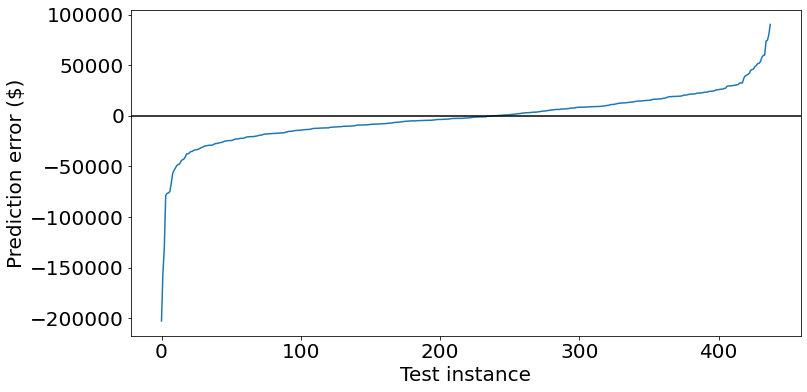

In [66]:
errors_orig = lr.predict(X_dev2) - y_dev
plot = errors_orig.sort_values(ascending=True).plot(use_index=False,figsize=(12,6),fontsize=20)
plot.axhline(color='black')
plot.set_ylabel("Prediction error ($)", fontsize=20)
plot.set_xlabel("Test instance", fontsize=20)

What is interesting to note is that while our model seems to underpredict a similar amount as it overpredicts, the highest underprediction is almost double the highest overprediction!


**Further Work**

Extensions of this project could include:


*   Trying polynomial features of the numeric columns
*   Scaling the data so that the coeficients can be interpreted
*   Possibly removing features that are highly correlated with other features



Thank you for reading!

